In [1]:
import itertools
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from matplotlib.axes import Axes
from matplotlib.collections import PathCollection
from matplotlib.colors import Colormap
from matplotlib.typing import ColorType, MarkerType
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.utilities import find_project_root
from src.visualization import plot

plot.set_mpl_styles(fontsize=10)

In [2]:
project_root = find_project_root()
feature_root = project_root / "reports/features"

cfg64_feature_path = feature_root / "SimpleCAE64/2023-07-21/20-18-22"
checkdata64 = pl.read_csv(
    cfg64_feature_path / "feature_check_data_clustering_VBGMM_iter1000.csv"
)
traindata64 = pl.read_csv(
    cfg64_feature_path / "feature_train_data_clustering_VBGMM_iter1000.csv"
)

cfg32_feature_path = feature_root / "SimpleCAE32/2023-07-10/13-09-32"
checkdata32 = pl.read_csv(
    cfg32_feature_path / "feature_check_data_clustering.csv"
)
traindata32 = pl.read_csv(
    cfg32_feature_path / "feature_train_data_clustering.csv"
)

cfg16_feature_path = feature_root / "SimpleCAE16/2025-02-04/08-12-21"
checkdata16 = pl.read_csv(
    cfg16_feature_path
    / "features_check_data_pca_with_clusters_2025-02-04-13-28-50.csv"
)
traindata16 = pl.read_csv(
    cfg16_feature_path
    / "features_train_data_pca_with_clusters_2025-02-04-13-28-50.csv"
)

In [3]:
# 64
std64 = StandardScaler()
pca64 = PCA()

X64_train = traindata64.select(pl.col(r"^column_\d+$")).to_numpy()
X64_train_std = std64.fit_transform(X64_train)
X64_train_pca = pca64.fit_transform(X64_train_std)

X64 = checkdata64.select(pl.col(r"^column_\d+$")).to_numpy()
X64_std = std64.transform(X64)
X64_pca = pca64.transform(X64_std)

# 32
std32 = StandardScaler()
pca32 = PCA()

X32_train = traindata32.select(pl.col(r"^column_\d+$")).to_numpy()
X32_train_std = std32.fit_transform(X32_train)
X32_train_pca = pca32.fit_transform(X32_train_std)

X32 = checkdata32.select(pl.col(r"^column_\d+$")).to_numpy()
X32_std = std32.transform(X32)
X32_pca = pca32.transform(X32_std)

In [4]:
pcadf64 = pl.concat(
    [pl.DataFrame(X64_pca), checkdata64.select(pl.exclude(r"^column_\d+$"))],
    # [pl.DataFrame(X64_train_pca), traindata64.select(pl.exclude(r"^column_\d+$"))],
    how="horizontal",
)
pcadf32 = pl.concat(
    [pl.DataFrame(X32_pca), checkdata32.select(pl.exclude(r"^column_\d+$"))],
    # [pl.DataFrame(X32_train_pca), traindata32.select(pl.exclude(r"^column_\d+$"))],
    how="horizontal",
)
pcadf16 = checkdata16

In [5]:
def scatter(
    df: pl.DataFrame, ax: Axes, cmap: Colormap | ColorType, markers: MarkerType
) -> list[PathCollection]:
    aggrigated = df.groupby("cluster").agg(
        pl.col("column_1").alias("pc1"), pl.col("column_2").alias("pc2")
    )
    paths: list[PathCollection] = []
    for c, pc1, pc2 in aggrigated.iter_rows():
        if isinstance(cmap, (list, tuple)):
            color = cmap[c]
        elif isinstance(cmap, Colormap):
            color = cmap(c)
        else:
            raise KeyError
        m = markers[c]
        if m == "x":
            p = ax.scatter(
                pc1,
                pc2,
                s=8,
                # alpha=0.5,
                color=color,
                label=f"cluster {c}",
                marker=m,
            )
        else:
            p = ax.scatter(
                pc1,
                pc2,
                s=8,
                # alpha=0.5,
                edgecolors=color,
                label=f"cluster {c}",
                marker=m,
                facecolor="none",
            )
        paths.append(p)

    return paths

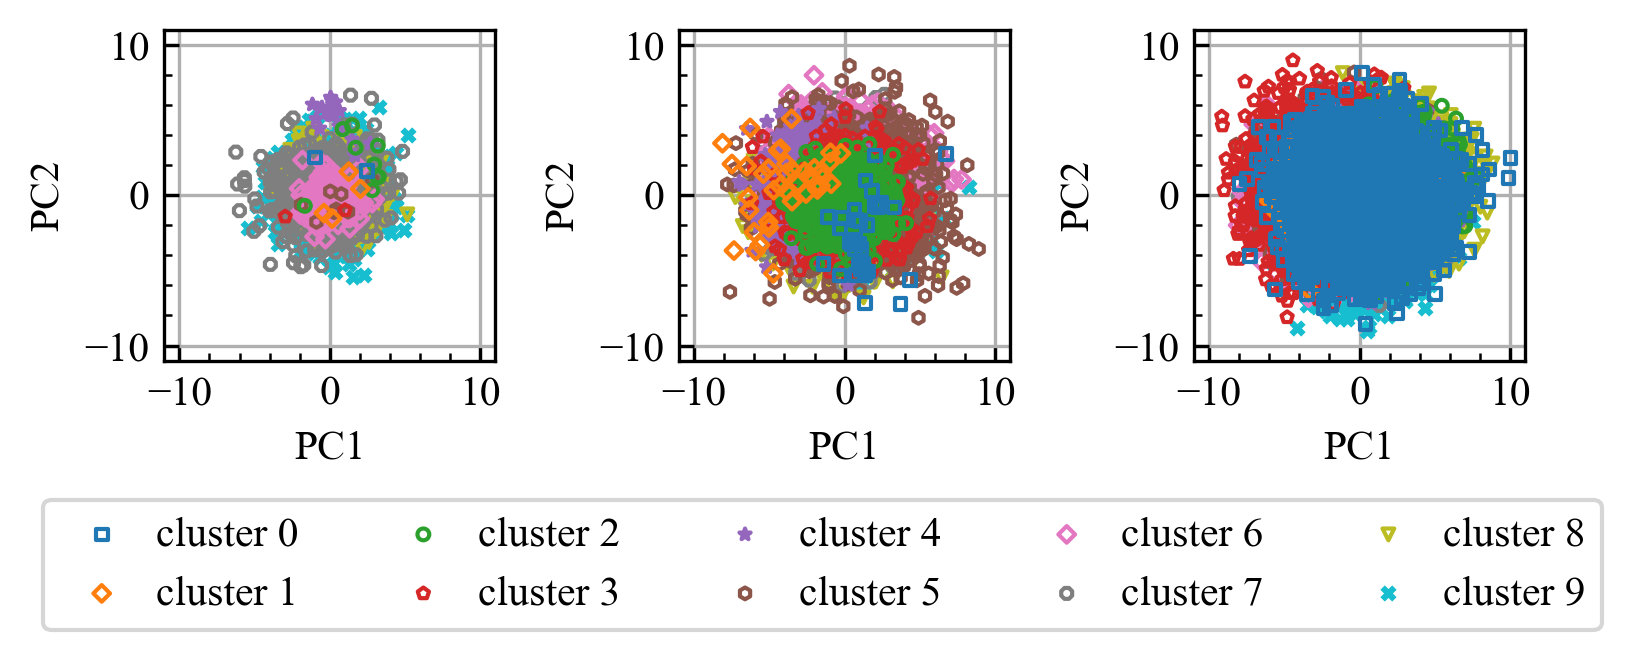

In [ ]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
markers = ["s", "D", "o", "p", "*", "h", "D", "8", "v", "x"]

figsize = plot.cvt_unit((15, 10))
fig = plt.figure(
    figsize=figsize,
    dpi=300,
)
fig.subplots_adjust(wspace=0.5, bottom=0.6)
axes: list[Axes] = []
for i, ddd in enumerate([pcadf64, pcadf32, pcadf16], 1):
    ax = fig.add_subplot(1, 3, i)
    cmap = plt.get_cmap("tab10")
    pcs = scatter(ddd, ax, colors, markers)
    ax.set_axisbelow(True)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    # ax.legend()
    for i, p in enumerate(pcs):
        p.set_zorder(len(pcs) - i)
    axes.append(ax)
plot.set_xy_axes_range(axes)
for ax in axes:
    ax.set_aspect("equal")
    plot.align_xy_ticks_interval(ax)
handle, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handle,
    labels,
    ncol=5,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.5),
    handletextpad=0.3,
)

In [12]:
checkdata16

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64
3.909896,0.017513,2.789482,-1.594559,-1.317011,-1.121971,0.583222,-0.327463,0.279306,0.716103,-1.432002,-2.32006,1.582042,1.915546,-2.055232,3.784871,-1.416673,-1.964454,-0.241695,-0.148774,0.964079,-0.458665,-0.042928,0.399187,-0.590006,-0.579055,0.275053,0.984069,-1.161893,-0.18413,-0.004487,0.341991,-0.562901,0.651382,-1.236997,0.018716,-0.608553,…,1.213719,0.151687,-0.35755,0.374364,-0.586038,-0.153093,1.08117,-0.384198,-0.640092,-1.098997,0.432928,-0.576666,0.385902,-0.267274,-0.487528,0.354141,-0.22905,0.802146,-0.864479,0.259423,-3.420457,0.744163,-0.314567,-0.415477,0.004865,-1.549049,0.53328,0.056843,-0.313383,-0.026686,-0.25466,-0.247136,1.5207,0.122344,0.430488,"""0/10k_0_h000_w…",7
-0.489395,0.166651,2.079455,-0.298616,0.038818,-1.504243,0.266689,-0.545914,0.723861,-0.226835,-0.090046,-1.710924,-0.088696,-1.556587,-3.240474,1.260337,-0.567071,0.177897,0.65431,0.809069,0.472578,1.542979,-1.249758,0.785928,-0.019485,-0.138602,-1.599265,0.353783,-0.767955,-0.523988,-0.454615,0.381973,-0.121936,0.776699,-0.572966,-0.693608,1.022739,…,0.695509,0.00571,-0.535395,-0.031727,-0.827729,-2.405123,-0.848615,-0.189572,-0.551038,0.25019,0.767021,0.580579,0.556492,-0.162817,-0.589447,-0.21438,1.238576,-0.45265,-0.861205,0.28791,-0.141841,-1.202502,-0.150486,-0.620561,-0.197168,-0.434318,-0.840115,0.256051,-0.468189,0.656955,-0.667686,0.729217,-0.927647,-0.076962,-0.433612,"""0/10k_0_h000_w…",6
-0.423368,-1.933436,4.186158,1.486108,0.545946,0.926188,0.222868,2.918995,-0.51822,-1.52236,-1.624348,0.879314,-1.653984,1.419608,-0.619706,-0.194606,-1.446438,-0.908858,0.086337,-0.401677,0.8649,0.214598,-0.002118,1.829368,0.097345,-0.577667,-0.128705,-0.576134,0.927247,-0.250537,-0.796279,0.117777,0.664557,0.085119,0.477147,-1.166453,-0.348093,…,-0.277656,0.32539,-1.454295,-0.275089,-1.417128,-0.262478,-0.536351,-2.144642,-0.048833,-0.836225,-0.453365,-0.113082,0.278473,-0.381943,-0.201537,-0.028467,0.841653,0.464683,-0.658067,-0.369671,0.33839,-0.039908,-0.056514,0.544972,0.596624,-0.306106,0.73286,-0.660342,-0.153333,-0.447707,0.541971,0.407944,-0.669105,0.470082,-0.432689,"""0/10k_0_h000_w…",6
-0.852858,0.354763,1.271996,2.363532,1.536588,-1.409375,-1.153592,2.113791,2.228987,-2.223996,-0.888495,0.616368,0.645375,-0.934876,1.073741,-3.487703,-0.482085,-0.176222,0.808432,0.110777,-0.838992,-1.214439,0.589024,-0.320296,0.21731,0.531617,0.9652,1.11238,-0.849735,-0.175432,-0.524293,-0.359721,-1.392914,-1.444247,-0.474104,-1.766736,2.0109,…,-0.430366,1.023743,0.711031,0.401218,0.585871,0.004688,0.250734,0.512383,0.788772,-1.453031,1.19069,0.500675,-0.720119,-0.79822,-0.082966,0.272273,0.791733,-0.139338,-1.556966,1.157935,0.222023,-0.48053,-0.757337,0.559346,-0.335827,-0.466559,0.210222,-0.525774,0.578946,-1.809466,1.058905,-0.21215,-0.551193,-0.160427,-0.928651,"""0/10k_0_h000_w…",6
-0.206324,1.307747,-1.061636,-0.149842,-1.981792,0.483895,-1.904952,-1.441298,2.119606,-0.403138,-0.047075,-0.643816,2.61371

In [53]:
sizeof64 = len(checkdata64)
cluster_per_total64 = (
    checkdata64.groupby(pl.col("cluster"))
    .agg(pl.col("cluster").count().alias("$64 \\times 64$ px") / sizeof64)
    .sort(pl.col("cluster"))
)
sizeof32 = len(checkdata32)
cluster_per_total32 = (
    checkdata32.groupby(pl.col("cluster"))
    .agg(pl.col("cluster").count().alias("$32 \\times 32$ px") / sizeof32)
    .sort(pl.col("cluster"))
)
sizeof16 = len(checkdata16)
cluster_per_total16 = (
    checkdata16.groupby(pl.col("cluster"))
    .agg(pl.col("cluster").count().alias("$16 \\times 16$ px") / sizeof16)
    .sort(pl.col("cluster"))
)

cluster_per_totals = cluster_per_total64.join(
    cluster_per_total32, on="cluster"
).join(cluster_per_total16, on="cluster")

In [54]:
cluster_per_totals

cluster,$64 \times 64$ px,$32 \times 32$ px,$16 \times 16$ px
i64,f64,f64,f64
0,0.000741,0.002963,0.062662
1,0.001481,0.003704,0.081806
2,0.003333,0.051296,0.090116
3,0.000741,0.08463,0.096597
4,0.006667,0.103056,0.107199
5,0.002963,0.104074,0.108241
6,0.066667,0.121111,0.111366
7,0.170741,0.145648,0.111134
8,0.214074,0.166481,0.114352


10

0.0
0.25
0.5


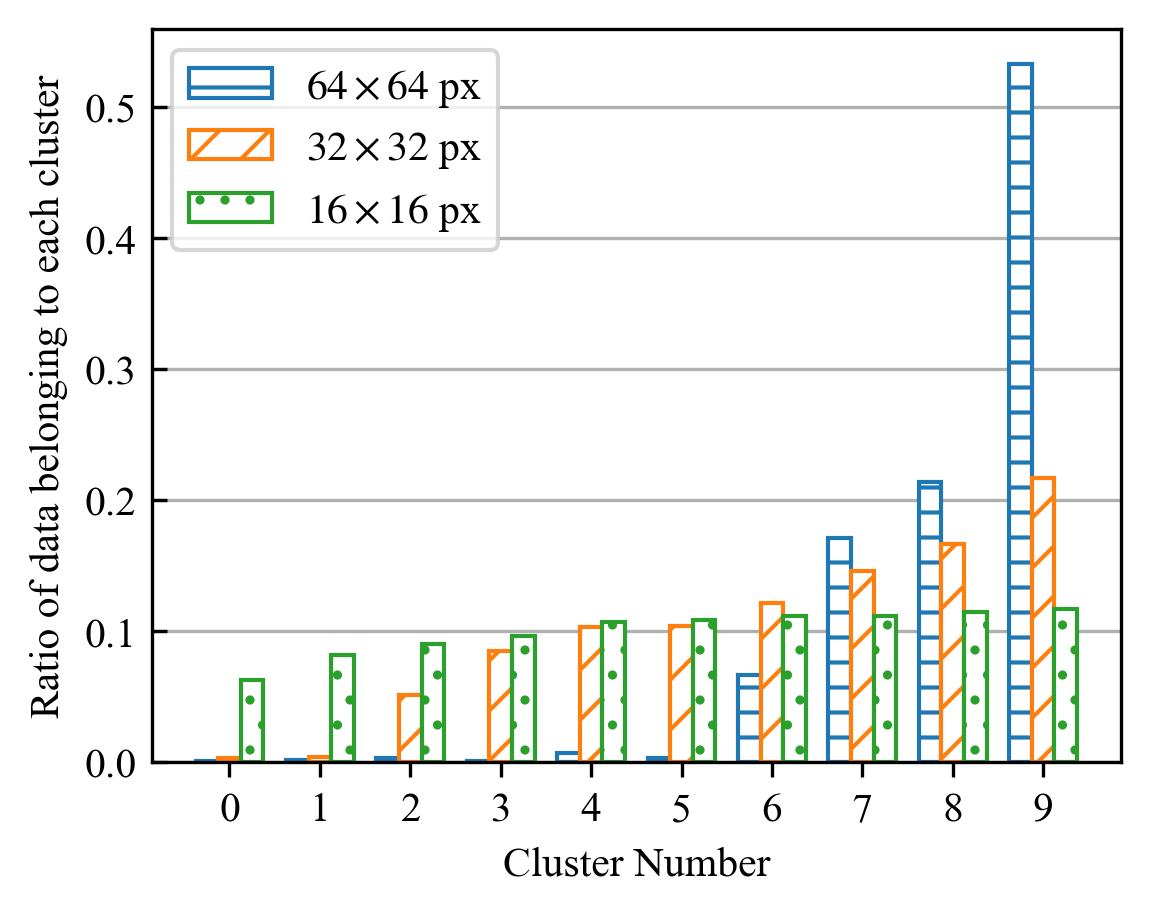

In [93]:
bar_location = cluster_per_totals.select("cluster").to_series().to_numpy()
bin_width = 0.25
height_cols = cluster_per_totals.columns[1:]
hatches = ["--", "//", ".."]
cmap = plt.get_cmap("tab10")

figsize = plot.cvt_unit((10, 8))
fig = plt.figure(figsize=figsize, layout="tight", dpi=300)
ax = fig.add_subplot()
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Ratio of data belonging to each cluster")
for i, (ddd, hatch) in enumerate(zip(height_cols, hatches)):
    loc_offset = bin_width * i
    print(loc_offset)
    height = cluster_per_totals.select(ddd).to_series().to_list()
    ax.bar(
        bar_location + loc_offset,
        height,
        width=bin_width,
        label=ddd,
        hatch=hatch,
        edgecolor=cmap(i),
        facecolor="white",
    )
xtick_loc = bar_location + loc_offset / 2
ax.set_xticks(
    xtick_loc,
    cluster_per_totals["cluster"],
)

ax.minorticks_off()
ax.tick_params(axis="x", direction="out")
ax.grid(axis="x")
ax.set_axisbelow(True)
ax.legend()

In [31]:
cluster_per_totals["64x64"]

64x64
f64
0.000741
0.001481
0.003333
0.000741
0.006667
0.002963
0.066667
0.170741
0.214074


In [94]:
dst = Path(
    "/home/shinsei/MyResearches/feat_extrc/reports/figures/SimpleCAE16/thesis-ch3/each_cluster_images/"
)
fig.savefig(
    dst / "data_ratio.svg",
    bbox_inches="tight",
)